# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import ta

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score,make_scorer, classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline

from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

# pip install arch
from arch import arch_model

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv("../datasets/labeled_data.csv")

In [3]:
df['local_time'] = pd.to_datetime(df['local_time'])
df.set_index('local_time', drop = True, inplace = True)

# Functions

In [4]:
# Function to Label whether each observation is a gain/lose/neutral
def label_gain(data,col):
    data['gain'] = ''
    for i in range(len(data)):
        # First Row
        if i == 0:
            if data[col][0] < data[col][1]:
                data['gain'][i] = 1
            else:
                data['gain'][i] = -1
        # Rest of the Rows        
        elif data[col][i] < data[col][i-1]:
            data['gain'][i] = -1
        elif data[col][i] > data[col][i-1]:
            data['gain'][i] = 1
        else:
            data['gain'][i] = 0

    return data

In [5]:
# Create Columns for pct_change up to 10 lags
def pct_change_col(data):
    for i in range(1,11):
        data['pct_change_'+str(i)] = df['predicted_price'].pct_change(-i)*100
    return data

In [6]:
# Create EMA(3) Columns for labeling
def ema3(data):
    data['ema_3'] = ta.trend.ema_indicator(close = data['predicted_price'], n=3, fillna=True)
    return data

In [7]:
# Split Dataframe to the last 100 rows
def split_100(data):
    return data[int(len(data))-100:].reset_index()

In [8]:
# Drop and Rename Columns
def drop_rename(data):
    data.dropna(inplace=True)
    data.drop(columns = ['pct_change_1', 'pct_change_2','pct_change_3', 'pct_change_4', 'pct_change_5', 'pct_change_6','pct_change_7', 'pct_change_8', 'pct_change_9', 'pct_change_10','ema_3'], inplace = True)
    data.rename(columns = {"gain": 'predicted_gain', "reversal": 'predicted_reversal'}, inplace=True)
    return data

In [9]:
# Replace 2 with 1 in the new reversal Column to check confusion matrix
def convert_label(data1,data2):
    data1['con_rev'] = data1['reversal'].copy()
    data1['con_rev'].replace(2,1,inplace = True)
    data2['con_pred_rev'] = data2['predicted_reversal'].copy()
    data2['con_pred_rev'].replace(2,1,inplace = True)
    return data1,data2

In [10]:
# Function to print report and confusion matrix
def print_reports(test, pred):
    report = classification_report(test['con_rev'], pred['con_pred_rev'])
    con_matrix = confusion_matrix(test['con_rev'], pred['con_pred_rev'])

    print(report)
    print(con_matrix)

In [11]:
# Conditions to Label whether the point is a postive reversal(1) or not(0)
# Conditions to Label whether the point is a negative reversal(2) or not(0)
def rev_label(data):
    signal = '' # Create Empty Signal for buy and sell toggling
    data['reversal'] = 0

    for index in range(len(data)):
        try:
            if signal == "buy": # If toggle is at buy, no more buy signals until first sell signal (2)
                if (data['gain'][index] == -1) & (data['gain'][index-1] == 1):
                    if (data['pct_change_10'][index-1] >= 3.75) or (data['pct_change_8'][index-1] >= 3.75) or (data['pct_change_6'][index-1] >= 3.75)  or (data['pct_change_2'][index-1] >= 3.75):#or (data['pct_change_6'][index-1] >= 0.363.75) or (data['pct_change_3.75'][index-1] >= 0.39) or (data['pct_change_2'][index-1] >= 0.3.751) or (data['pct_change_1'][index-1] >= 0.3.753.75):
                        if data['ema_3'][index+2] > data['predicted_price'][index+2]:
                            data['reversal'][index-2] = 2
                            signal = 'sell' # Change signal to Sell

            elif signal == 'sell': # If toggle is at sell, no more sell signals until first buy signal(1)
                if (data['gain'][index] == 1) & (data['gain'][index-1] == -1):
                    if (data['pct_change_10'][index-1] <= -3.75) or (data['pct_change_8'][index-1] <= -3.75) or (data['pct_change_6'][index-1] <= -3.75) or (data['pct_change_2'][index-1] <= -3.75): #or (data['pct_change_6'][index-1] <= -0.363.75) or (data['pct_change_3.75'][index-1] <= -0.39) or (data['pct_change_2'][index-1] <= -0.3.751) or (data['pct_change_1'][index-1] <= -0.3.753.75):
                        if (data['pct_change_10'][index] >= -100) or (data['pct_change_9'][index] >= -100) or (data['pct_change_8'][index] >= -100) or (data['pct_change_7'][index] >= -100) or (data['pct_change_6'][index] >= -100):
                            if data['ema_3'][index+2] < data['predicted_price'][index+2]:
                                data['reversal'][index-2] = 1
                                signal = 'buy' # Change signal to Buy
            
            else: # At the start where there is no signals yet
                if (data['gain'][index] == -1) & (data['gain'][index-1] == 1):
                    if (data['pct_change_10'][index-1] >= 3.75) or (data['pct_change_8'][index-1] >= 3.75) or (data['pct_change_6'][index-1] >= 3.75)  or (data['pct_change_2'][index-1] >= 3.75):#or (data['pct_change_6'][index-1] >= 0.363.75) or (data['pct_change_3.75'][index-1] >= 0.39) or (data['pct_change_2'][index-1] >= 0.3.751) or (data['pct_change_1'][index-1] >= 0.3.753.75):
                        if data['ema_3'][index+2] > data['predicted_price'][index+2]:
                            data['reversal'][index-2] = 2
                            signal = 'sell' # Change signal to Sell
                elif (data['gain'][index] == 1) & (data['gain'][index-1] == -1):
                    if (data['pct_change_10'][index-1] <= -3.75) or (data['pct_change_8'][index-1] <= -3.75) or (data['pct_change_6'][index-1] <= -3.75) or (data['pct_change_2'][index-1] <= -3.75): #or (data['pct_change_6'][index-1] <= -0.363.75) or (data['pct_change_3.75'][index-1] <= -0.39) or (data['pct_change_2'][index-1] <= -0.3.751) or (data['pct_change_1'][index-1] <= -0.3.753.75):
                        if (data['pct_change_10'][index] >= -100) or (data['pct_change_9'][index] >= -100) or (data['pct_change_8'][index] >= -100) or (data['pct_change_7'][index] >= -100) or (data['pct_change_6'][index] >= -100):
                            if data['ema_3'][index+2] < data['predicted_price'][index+2]:
                                data['reversal'][index-2] = 1
                                signal = 'buy' # Change signal to Buy
                else:
                    data['reversal'][index-2] = 0
            
        except:
            print('test')

# Split Dataset into respective stocks

In [12]:
# Split Dataset
aapl = df[df['stock'] == "AAPL"]
crm = df[df['stock'] == "CRM"]
dis = df[df['stock'] == "DIS"]
fb = df[df['stock'] == "FB"]
gm = df[df['stock'] == "GM"]
intc = df[df['stock'] == "INTC"]
nke = df[df['stock'] == "NKE"]
trip = df[df['stock'] == "TRIP"]
twtr = df[df['stock'] == "TWTR"]
v = df[df['stock'] == "V"]

# SARIMA

In [13]:
aapl_sarima = aapl[['close_price']]
crm_sarima = crm[['close_price']]
dis_sarima = dis[['close_price']]
fb_sarima = fb[['close_price']]
gm_sarima = gm[['close_price']]
intc_sarima = intc[['close_price']]
nke_sarima = nke[['close_price']]
trip_sarima = trip[['close_price']]
twtr_sarima = twtr[['close_price']]
v_sarima = v[['close_price']]

## APPLE

### Train Test Split

In [14]:
# Train test split
train_data, test_data = aapl_sarima[0:int(len(aapl_sarima)-100)], aapl_sarima[int(len(aapl_sarima)-100):]

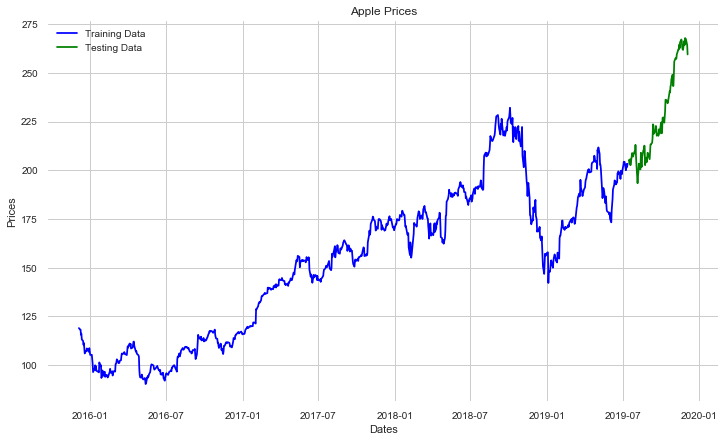

In [15]:
# Plot the figure
plt.figure(figsize=(12,7))
plt.title('Apple Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data, 'blue', label='Training Data')
plt.plot(test_data, 'green', label='Testing Data')
plt.legend()

### Test Model

In [16]:
# Running Forecast
train_ar = train_data.values
test_ar = test_data.values
history = [x for x in train_ar]
print(type(history))
predictions_aapl = list()
for t in range(len(test_ar)):
    if (t == len(test_ar) - 1):
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3,1,0,8))
        model_fit = model.fit(disp = 0)
        output = model_fit.forecast(steps = 13)
        print(output)
        for i in output:
            yhat = i
            predictions_aapl.append(yhat)
        obs = test_ar[t]
        history.append(obs)
    else:
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3,1,0,8))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
#         for i in output[0]:
#             yhat = i
#             predictions.append(yhat)
        yhat = output[0]
        predictions_aapl.append(yhat)
        obs = test_ar[t]
        history.append(obs)
error = mean_squared_error(test_ar, predictions[:100])
print(f'Testing Mean Squared Error: {error}')

<class 'list'>


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sta

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

[262.34133855 262.71340302 264.28981352 267.12123877 266.99217335
 268.46040173 269.12321347 268.99039524 266.08427428 265.88061305
 267.19811913 271.35105213 270.41948635]


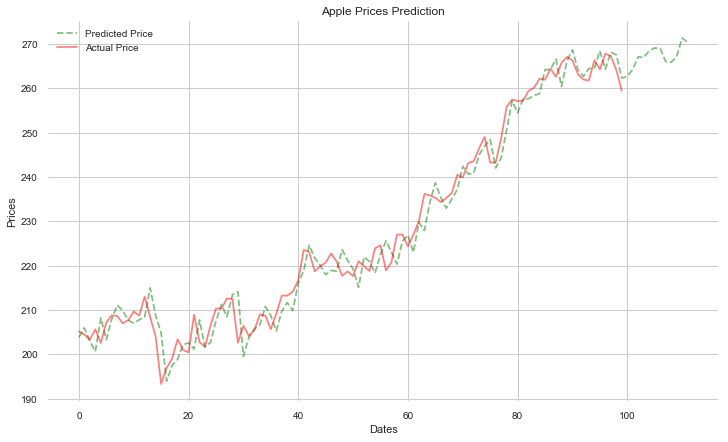

In [17]:
# Plot Prediction against test price
plt.figure(figsize=(12,7))
plt.plot(pd.DataFrame(predictions_aapl).reset_index(drop=True).index, predictions_aapl, color='green', alpha = 0.5, linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.reset_index(drop=True).index, test_data, color='red', alpha = 0.5, label='Actual Price')
plt.title('Apple Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

## CRM

### Train Test Split

In [18]:
# Train test split
train_data, test_data = crm_sarima[0:int(len(crm_sarima)-100)], crm_sarima[int(len(crm_sarima)-100):]

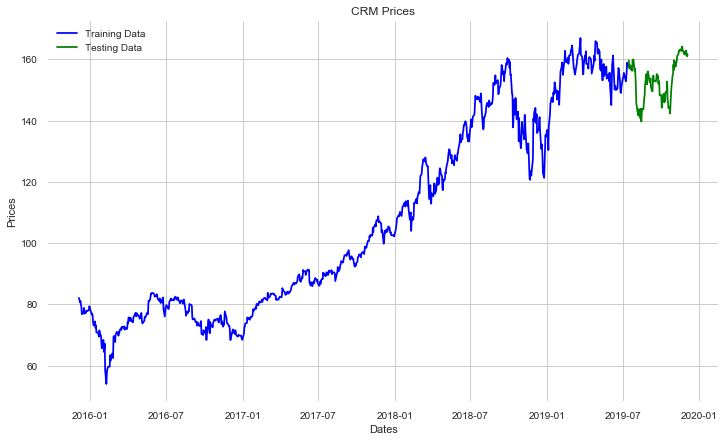

In [19]:
# Plot the figure
plt.figure(figsize=(12,7))
plt.title('CRM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data, 'blue', label='Training Data')
plt.plot(test_data, 'green', label='Testing Data')
plt.legend()

### Test Model

In [21]:
# Running Forecast
train_ar = train_data.values
test_ar = test_data.values
history = [x for x in train_ar]
print(type(history))
predictions_crm = list()
for t in range(len(test_ar)):
    if (t == len(test_ar) - 1):
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3,1,0,8),initialization='approximate_diffuse')
        model_fit = model.fit(disp = 0)
        output = model_fit.forecast(steps = 13)
        print(output)
        for i in output:
            yhat = i
            predictions_crm.append(yhat)
        obs = test_ar[t]
        history.append(obs)
    else:
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3,1,0,8),initialization='approximate_diffuse')
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
#         for i in output[0]:
#             yhat = i
#             predictions.append(yhat)
        yhat = output[0]
        predictions_crm.append(yhat)
        obs = test_ar[t]
        history.append(obs)
error = mean_squared_error(test_ar, predictions[:100])
print(f'Testing Mean Squared Error: {error}')

<class 'list'>


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

[161.11891162 161.16670254 160.72974306 160.57400423 160.67062716
 161.20807352 161.88340833 162.94706915 163.38589892 163.77662459
 163.39355394 163.58903014 163.32565523]


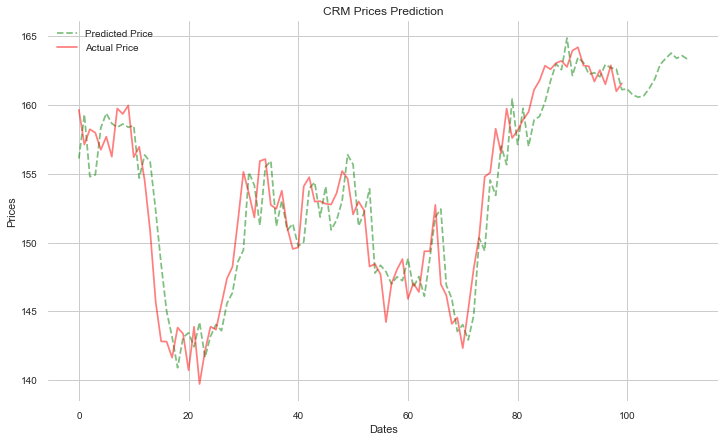

In [22]:
# Plot Prediction against test price
plt.figure(figsize=(12,7))
plt.plot(pd.DataFrame(predictions_crm).reset_index(drop=True).index, predictions_crm, color='green', alpha = 0.5, linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.reset_index(drop=True).index, test_data, color='red', alpha = 0.5, label='Actual Price')
plt.title('CRM Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

## DIS

### Train Test Split

In [23]:
# Train test split
train_data, test_data = dis_sarima[0:int(len(dis_sarima)-100)], dis_sarima[int(len(dis_sarima)-100):]

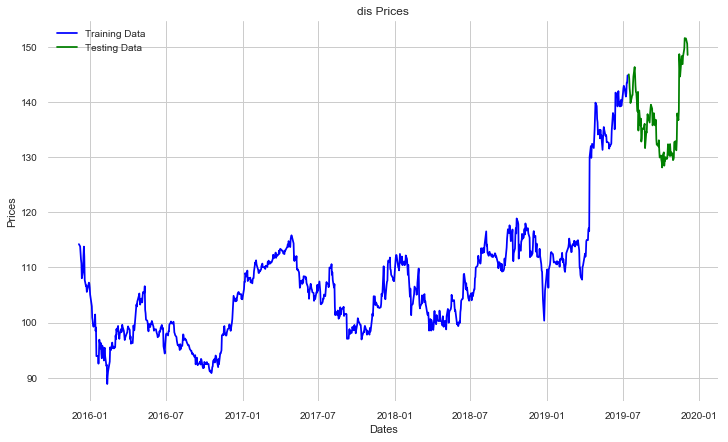

In [24]:
# Plot the figure
plt.figure(figsize=(12,7))
plt.title('dis Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data, 'blue', label='Training Data')
plt.plot(test_data, 'green', label='Testing Data')
plt.legend()

### Test Model

In [25]:
# Running Forecast
train_ar = train_data.values
test_ar = test_data.values
history = [x for x in train_ar]
print(type(history))
predictions_dis = list()
for t in range(len(test_ar)):
    if (t == len(test_ar) - 1):
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3,1,0,8))
        model_fit = model.fit(disp = 0)
        output = model_fit.forecast(steps = 13)
        print(output)
        for i in output:
            yhat = i
            predictions_dis.append(yhat)
        obs = test_ar[t]
        history.append(obs)
    else:
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3,1,0,8))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
#         for i in output[0]:
#             yhat = i
#             predictions.append(yhat)
        yhat = output[0]
        predictions_dis.append(yhat)
        obs = test_ar[t]
        history.append(obs)
error = mean_squared_error(test_ar, predictions[:100])
print(f'Testing Mean Squared Error: {error}')

<class 'list'>


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

[151.16895772 149.55108654 149.42924296 152.91211148 152.56827761
 150.66012989 151.09632761 150.89522212 150.95144197 149.6897063
 150.17641645 154.05436819 153.54674637]


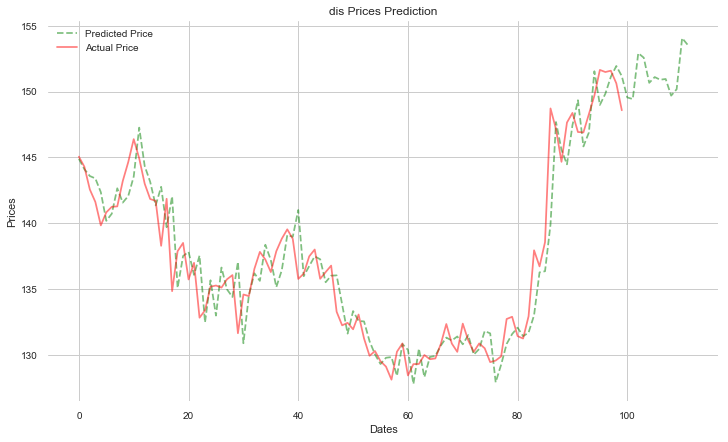

In [26]:
# Plot Prediction against test price
plt.figure(figsize=(12,7))
plt.plot(pd.DataFrame(predictions_dis).reset_index(drop=True).index, predictions_dis, color='green', alpha = 0.5, linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.reset_index(drop=True).index, test_data, color='red', alpha = 0.5, label='Actual Price')
plt.title('dis Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

## FB

### Train Test Split

In [27]:
# Train test split
train_data, test_data = fb_sarima[0:int(len(fb_sarima)-100)], fb_sarima[int(len(fb_sarima)-100):]

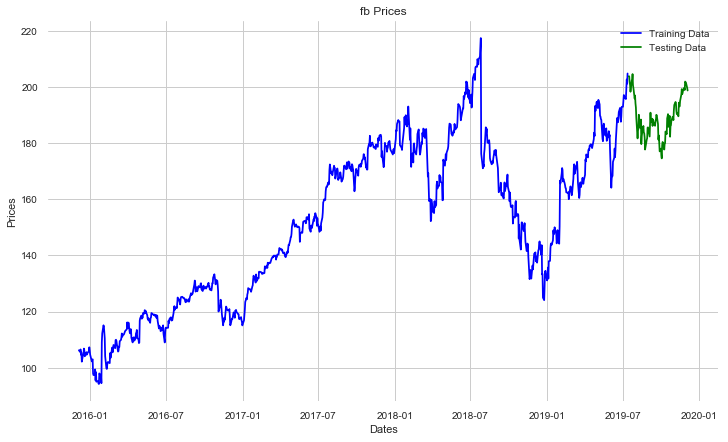

In [28]:
# Plot the figure
plt.figure(figsize=(12,7))
plt.title('fb Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data, 'blue', label='Training Data')
plt.plot(test_data, 'green', label='Testing Data')
plt.legend()

### Test Model

In [29]:
# Running Forecast
train_ar = train_data.values
test_ar = test_data.values
history = [x for x in train_ar]
print(type(history))
predictions_fb = list()
for t in range(len(test_ar)):
    if (t == len(test_ar) - 1):
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3,1,0,8))
        model_fit = model.fit(disp = 0)
        output = model_fit.forecast(steps = 13)
        print(output)
        for i in output:
            yhat = i
            predictions_fb.append(yhat)
        obs = test_ar[t]
        history.append(obs)
    else:
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3,1,0,8))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
#         for i in output[0]:
#             yhat = i
#             predictions.append(yhat)
        yhat = output[0]
        predictions_fb.append(yhat)
        obs = test_ar[t]
        history.append(obs)
error = mean_squared_error(test_ar, predictions[:100])
print(f'Testing Mean Squared Error: {error}')

<class 'list'>


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

[199.40428031 197.47396976 200.18631973 198.176687   199.13400035
 200.04765962 199.79219844 199.79354409 199.2332815  198.10868782
 200.40361613 200.29789799 200.49844023]


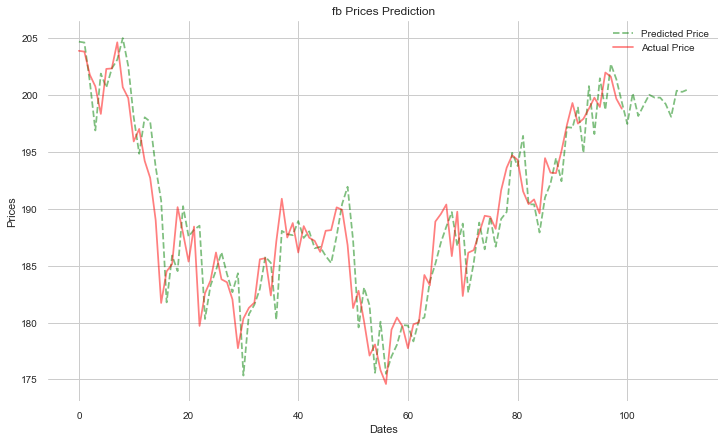

In [30]:
# Plot Prediction against test price
plt.figure(figsize=(12,7))
plt.plot(pd.DataFrame(predictions_fb).reset_index(drop=True).index, predictions_fb, color='green', alpha = 0.5, linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.reset_index(drop=True).index, test_data, color='red', alpha = 0.5, label='Actual Price')
plt.title('fb Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

## GM

### Train Test Split

In [31]:
# Train test split
train_data, test_data = gm_sarima[0:int(len(gm_sarima)-100)], gm_sarima[int(len(gm_sarima)-100):]

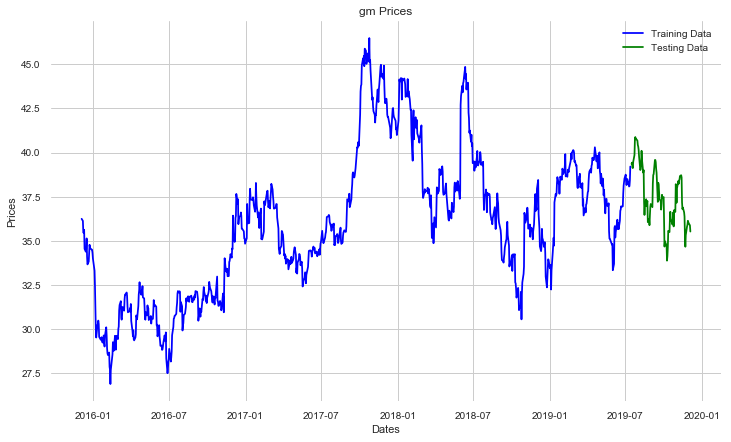

In [32]:
# Plot the figure
plt.figure(figsize=(12,7))
plt.title('gm Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data, 'blue', label='Training Data')
plt.plot(test_data, 'green', label='Testing Data')
plt.legend()

### Test Model

In [33]:
# Running Forecast
train_ar = train_data.values
test_ar = test_data.values
history = [x for x in train_ar]
print(type(history))
predictions_gm = list()
for t in range(len(test_ar)):
    if (t == len(test_ar) - 1):
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3,1,0,8),initialization='approximate_diffuse')
        model_fit = model.fit(disp = 0)
        output = model_fit.forecast(steps = 13)
        print(output)
        for i in output:
            yhat = i
            predictions_gm.append(yhat)
        obs = test_ar[t]
        history.append(obs)
    else:
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3,1,0,8),initialization='approximate_diffuse')
        model_fit = model.fit(disp = 0)
        output = model_fit.forecast()
#         for i in output[0]:
#             yhat = i
#             predictions.append(yhat)
        yhat = output[0]
        predictions_gm.append(yhat)
        obs = test_ar[t]
        history.append(obs)
error = mean_squared_error(test_ar, predictions[:100])
print(f'Testing Mean Squared Error: {error}')

<class 'list'>


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

[36.0404164  35.91724217 35.81919546 35.90418891 36.0550552  35.93532825
 36.15971881 36.10400971 36.32604131 36.10899083 36.07957373 36.10916641
 36.20851574]


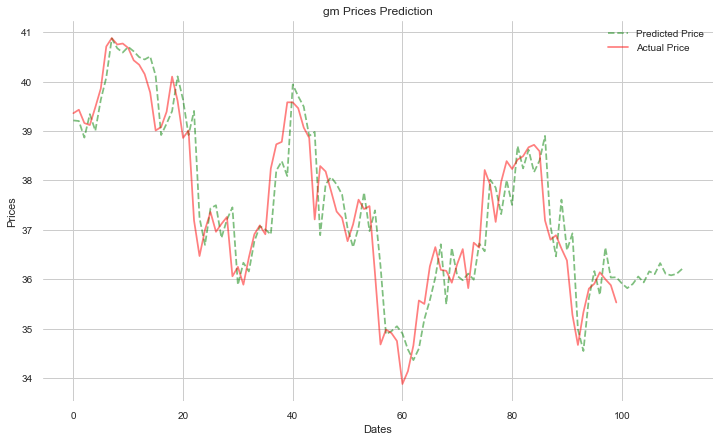

In [34]:
# Plot Prediction against test price
plt.figure(figsize=(12,7))
plt.plot(pd.DataFrame(predictions_gm).reset_index(drop=True).index, predictions_gm, color='green', alpha = 0.5, linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.reset_index(drop=True).index, test_data, color='red', alpha = 0.5, label='Actual Price')
plt.title('gm Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

## INTC

### Train Test Split

In [35]:
# Train test split
train_data, test_data = intc_sarima[0:int(len(intc_sarima)-100)], intc_sarima[int(len(intc_sarima)-100):]

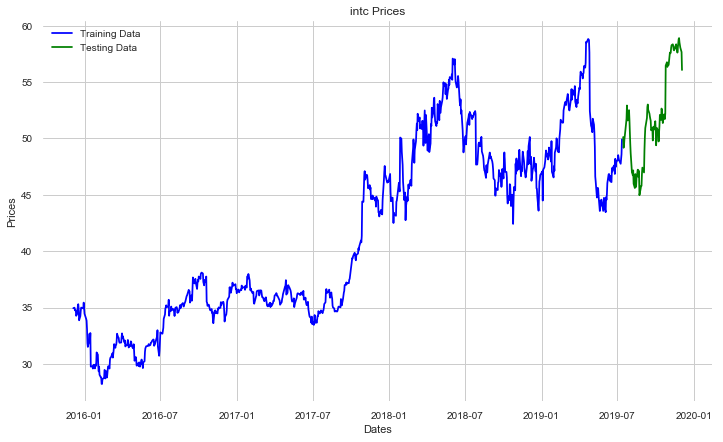

In [36]:
# Plot the figure
plt.figure(figsize=(12,7))
plt.title('intc Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data, 'blue', label='Training Data')
plt.plot(test_data, 'green', label='Testing Data')
plt.legend()

### Test Model

In [38]:
# Running Forecast
train_ar = train_data.values
test_ar = test_data.values
history = [x for x in train_ar]
print(type(history))
predictions_intc = list()
for t in range(len(test_ar)):
    if (t == len(test_ar) - 1):
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3,1,0,8),initialization='approximate_diffuse')
        model_fit = model.fit(disp = 0)
        output = model_fit.forecast(steps = 13)
        print(output)
        for i in output:
            yhat = i
            predictions_intc.append(yhat)
        obs = test_ar[t]
        history.append(obs)
    else:
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3,1,0,8),initialization='approximate_diffuse')
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
#         for i in output[0]:
#             yhat = i
#             predictions.append(yhat)
        yhat = output[0]
        predictions_intc.append(yhat)
        obs = test_ar[t]
        history.append(obs)
error = mean_squared_error(test_ar, predictions[:100])
print(f'Testing Mean Squared Error: {error}')

<class 'list'>


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[57.20726042 57.01296032 56.9304453  57.08851313 57.23417955 57.2456352
 58.18515694 58.26684401 57.94715294 58.04742477 57.7661808  58.06320933
 58.33776649]


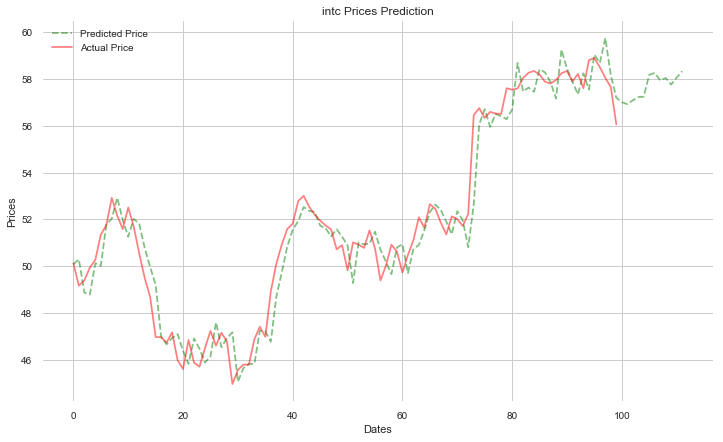

In [39]:
# Plot Prediction against test price
plt.figure(figsize=(12,7))
plt.plot(pd.DataFrame(predictions_intc).reset_index(drop=True).index, predictions_intc, color='green', alpha = 0.5, linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.reset_index(drop=True).index, test_data, color='red', alpha = 0.5, label='Actual Price')
plt.title('intc Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

## NKE

### Train Test Split

In [40]:
# Train test split
train_data, test_data = nke_sarima[0:int(len(nke_sarima)-100)], nke_sarima[int(len(nke_sarima)-100):]

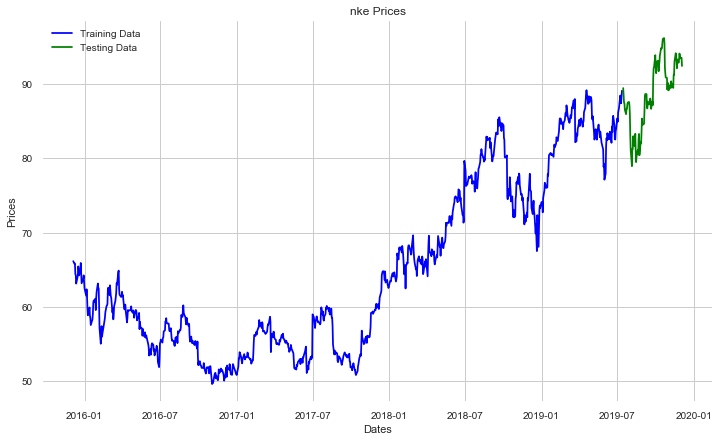

In [41]:
# Plot the figure
plt.figure(figsize=(12,7))
plt.title('nke Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data, 'blue', label='Training Data')
plt.plot(test_data, 'green', label='Testing Data')
plt.legend()

### Test Model

In [42]:
# Running Forecast
train_ar = train_data.values
test_ar = test_data.values
history = [x for x in train_ar]
print(type(history))
predictions_nke = list()
for t in range(len(test_ar)):
    if (t == len(test_ar) - 1):
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3,1,0,8))
        model_fit = model.fit(disp = 0)
        output = model_fit.forecast(steps = 13)
        print(output)
        for i in output:
            yhat = i
            predictions_nke.append(yhat)
        obs = test_ar[t]
        history.append(obs)
    else:
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3,1,0,8))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
#         for i in output[0]:
#             yhat = i
#             predictions.append(yhat)
        yhat = output[0]
        predictions_nke.append(yhat)
        obs = test_ar[t]
        history.append(obs)
error = mean_squared_error(test_ar, predictions[:100])
print(f'Testing Mean Squared Error: {error}')

<class 'list'>


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

[93.23327946 93.12577723 93.25848925 93.27968695 92.82429698 93.19273407
 93.27650348 93.06533618 92.37869528 92.14433501 92.36047601 92.31639162
 92.54764885]


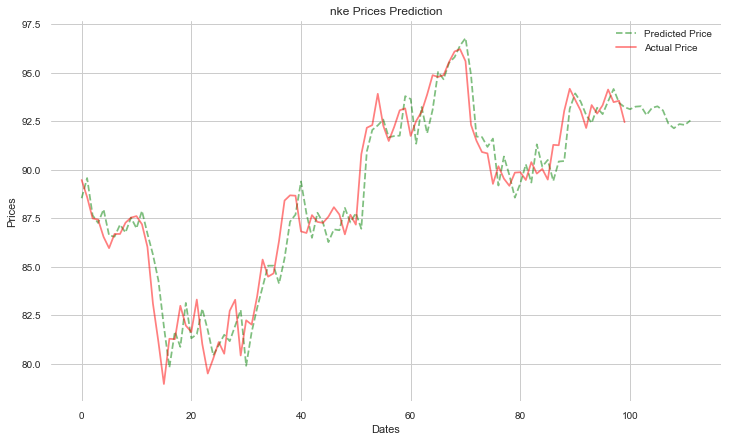

In [43]:
# Plot Prediction against test price
plt.figure(figsize=(12,7))
plt.plot(pd.DataFrame(predictions_nke).reset_index(drop=True).index, predictions_nke, color='green', alpha = 0.5, linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.reset_index(drop=True).index, test_data, color='red', alpha = 0.5, label='Actual Price')
plt.title('nke Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

## TRIP

### Train Test Split

In [44]:
# Train test split
train_data, test_data = trip_sarima[0:int(len(trip_sarima)-100)], trip_sarima[int(len(trip_sarima)-100):]

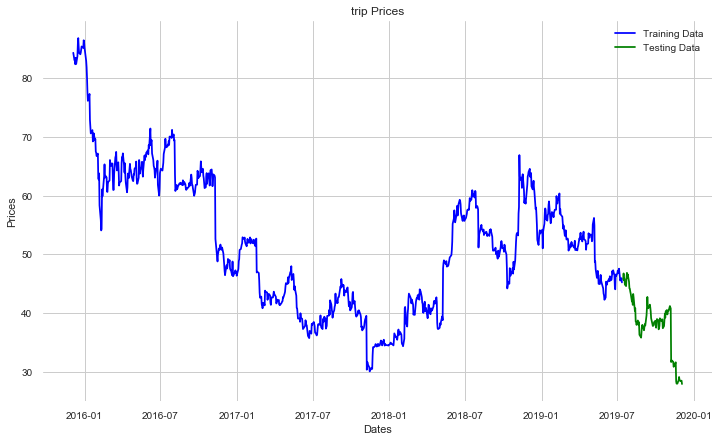

In [45]:
# Plot the figure
plt.figure(figsize=(12,7))
plt.title('trip Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data, 'blue', label='Training Data')
plt.plot(test_data, 'green', label='Testing Data')
plt.legend()

### Test Model

In [46]:
# Running Forecast
train_ar = train_data.values
test_ar = test_data.values
history = [x for x in train_ar]
print(type(history))
predictions_trip = list()
for t in range(len(test_ar)):
    if (t == len(test_ar) - 1):
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3,1,0,8),initialization='approximate_diffuse')
        model_fit = model.fit(disp = 0)
        output = model_fit.forecast(steps = 13)
        print(output)
        for i in output:
            yhat = i
            predictions_trip.append(yhat)
        obs = test_ar[t]
        history.append(obs)
    else:
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3,1,0,8),initialization='approximate_diffuse')
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
#         for i in output[0]:
#             yhat = i
#             predictions.append(yhat)
        yhat = output[0]
        predictions_trip.append(yhat)
        obs = test_ar[t]
        history.append(obs)
error = mean_squared_error(test_ar, predictions[:100])
print(f'Testing Mean Squared Error: {error}')

<class 'list'>


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

[28.78762172 28.91769376 29.4340378  29.68234344 30.67136755 30.53672402
 31.00532521 28.21812669 28.33909484 28.627345   28.94997793 29.14783015
 29.94714505]


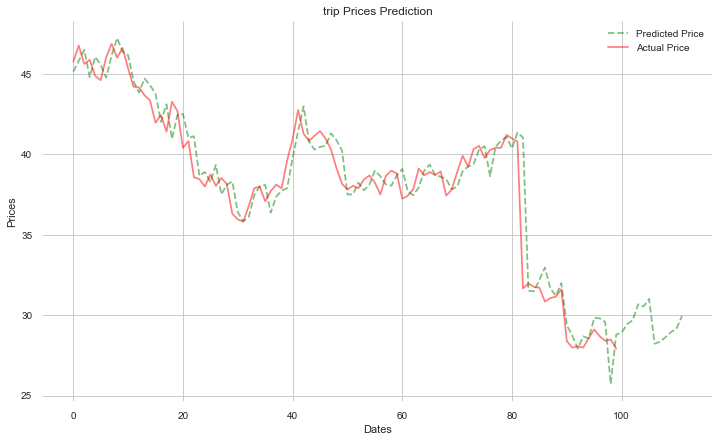

In [47]:
# Plot Prediction against test price
plt.figure(figsize=(12,7))
plt.plot(pd.DataFrame(predictions_trip).reset_index(drop=True).index, predictions_trip, color='green', alpha = 0.5, linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.reset_index(drop=True).index, test_data, color='red', alpha = 0.5, label='Actual Price')
plt.title('trip Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

## TWTR

### Train Test Split

In [48]:
# Train test split
train_data, test_data = twtr_sarima[0:int(len(twtr_sarima)-100)], twtr_sarima[int(len(twtr_sarima)-100):]

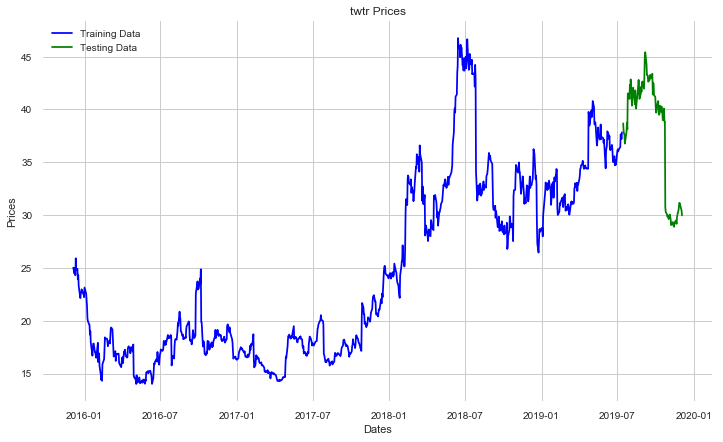

In [49]:
# Plot the figure
plt.figure(figsize=(12,7))
plt.title('twtr Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data, 'blue', label='Training Data')
plt.plot(test_data, 'green', label='Testing Data')
plt.legend()

### Test Model

In [50]:
# Running Forecast
train_ar = train_data.values
test_ar = test_data.values
history = [x for x in train_ar]
print(type(history))
predictions_twtr = list()
for t in range(len(test_ar)):
    if (t == len(test_ar) - 1):
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3,1,0,8),initialization='approximate_diffuse')
        model_fit = model.fit(disp = 0)
        output = model_fit.forecast(steps = 13)
        print(output)
        for i in output:
            yhat = i
            predictions_twtr.append(yhat)
        obs = test_ar[t]
        history.append(obs)
    else:
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3,1,0,8),initialization='approximate_diffuse')
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
#         for i in output[0]:
#             yhat = i
#             predictions.append(yhat)
        yhat = output[0]
        predictions_twtr.append(yhat)
        obs = test_ar[t]
        history.append(obs)
error = mean_squared_error(test_ar, predictions[:100])
print(f'Testing Mean Squared Error: {error}')

<class 'list'>


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

[30.36878901 30.4538756  30.92037101 30.7352132  30.99864984 28.90453674
 28.77934311 28.53194858 28.49536854 28.75377581 28.99016249 29.01402202
 29.33089283]


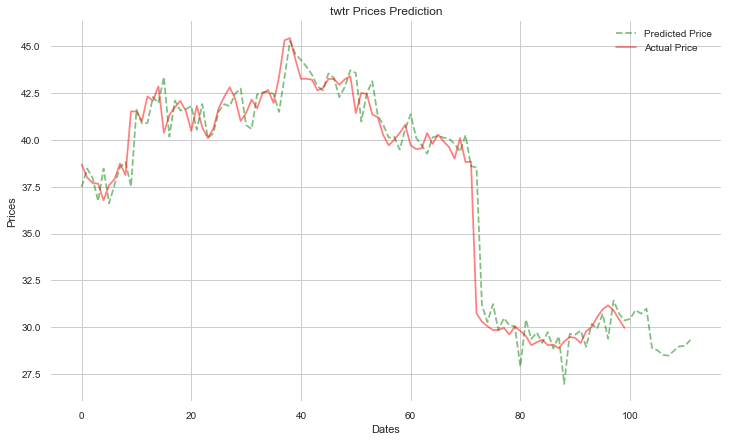

In [51]:
# Plot Prediction against test price
plt.figure(figsize=(12,7))
plt.plot(pd.DataFrame(predictions_twtr).reset_index(drop=True).index, predictions_twtr, color='green', alpha = 0.5, linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.reset_index(drop=True).index, test_data, color='red', alpha = 0.5, label='Actual Price')
plt.title('twtr Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

## V

### Train Test Split

In [52]:
# Train test split
train_data, test_data = v_sarima[0:int(len(v_sarima)-100)], v_sarima[int(len(v_sarima)-100):]

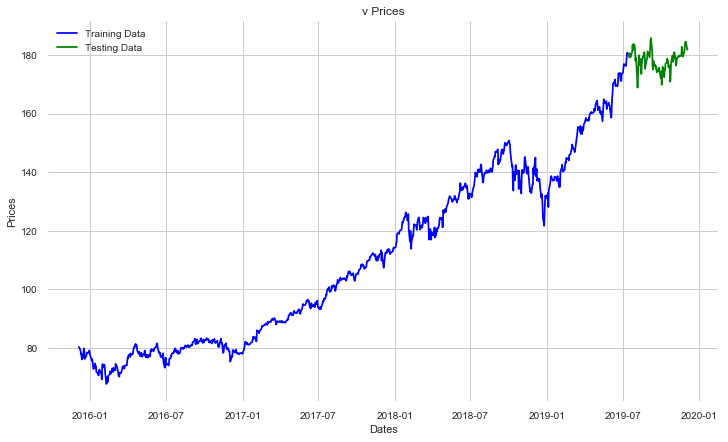

In [53]:
# Plot the figure
plt.figure(figsize=(12,7))
plt.title('v Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data, 'blue', label='Training Data')
plt.plot(test_data, 'green', label='Testing Data')
plt.legend()

### Test Model

In [54]:
# Running Forecast
train_ar = train_data.values
test_ar = test_data.values
history = [x for x in train_ar]
print(type(history))
predictions_v = list()
for t in range(len(test_ar)):
    if (t == len(test_ar) - 1):
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3,1,0,8))
        model_fit = model.fit(disp = 0)
        output = model_fit.forecast(steps = 13)
        print(output)
        for i in output:
            yhat = i
            predictions_v.append(yhat)
        obs = test_ar[t]
        history.append(obs)
    else:
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3,1,0,8))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
#         for i in output[0]:
#             yhat = i
#             predictions.append(yhat)
        yhat = output[0]
        predictions_v.append(yhat)
        obs = test_ar[t]
        history.append(obs)
error = mean_squared_error(test_ar, predictions[:100])
print(f'Testing Mean Squared Error: {error}')

<class 'list'>


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

[181.1358628  180.386659   180.43985646 179.98300639 179.78013145
 180.46246282 181.08389027 182.24095449 181.08995989 180.83153011
 180.83205692 181.4882046  181.22622391]


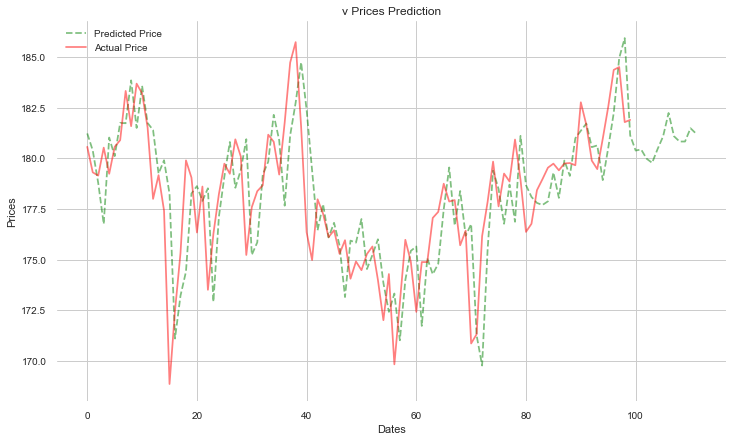

In [55]:
# Plot Prediction against test price
plt.figure(figsize=(12,7))
plt.plot(pd.DataFrame(predictions_v).reset_index(drop=True).index, predictions_v, color='green', alpha = 0.5, linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.reset_index(drop=True).index, test_data, color='red', alpha = 0.5, label='Actual Price')
plt.title('v Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

# Create Labels

In [56]:
# Lists to use for loop
pred_list = [predictions_aapl,predictions_crm,predictions_dis,predictions_fb,predictions_gm,predictions_intc,predictions_nke,predictions_trip,predictions_twtr,predictions_v]
df_list = ['aapl_pred','crm_pred','dis_pred','fb_pred','gm_pred','intc_pred','nke_pred','trip_pred','twtr_pred','v_pred']

In [57]:
# Set predicted price into their own DataFrame
for df_name,pred in zip(df_list,pred_list):
    globals()[f'{df_name}'] = pd.DataFrame({"predicted_price":pred})

## Create Gain Column for Predictions

In [58]:
df_listed = [aapl_pred,crm_pred,dis_pred,fb_pred,gm_pred,intc_pred,nke_pred,trip_pred,twtr_pred,v_pred]
for df in df_listed:
    df = label_gain(df,'predicted_price')

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/ipy

## Create % Change columns up to 10

In [59]:
# Create %change Columns
df_listed = [aapl_pred,crm_pred,dis_pred,fb_pred,gm_pred,intc_pred,nke_pred,trip_pred,twtr_pred,v_pred]
for df in df_listed:
    df = pct_change_col(df)

## Create EMA 3 Column

In [60]:
df_listed = [aapl_pred,crm_pred,dis_pred,fb_pred,gm_pred,intc_pred,nke_pred,trip_pred,twtr_pred,v_pred]
for df in df_listed:
    df = ema3(df)

## Apply Function to Label Reversal Points

In [61]:
df_listed = [aapl_pred,crm_pred,dis_pred,fb_pred,gm_pred,intc_pred,nke_pred,trip_pred,twtr_pred,v_pred]
for df in df_listed:
    df = rev_label(df)

test


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarni

test


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


test
test
test
test
test
test
test
test


# Check Accuracy of Predicted Reversals with Main Data

## Split main data into the last 100 rows (Test)

In [62]:
list_main = [aapl, crm, dis, fb, gm, intc, nke, trip, twtr, v]
test_name = ['aapl_test', 'crm_test', 'dis_test', 'fb_test', 'gm_test', 'intc_test', 'nke_test', 'trip_test', 'twtr_test', 'v_test']

In [63]:
for df_name,main in zip(test_name,list_main):
    globals()[f'{df_name}'] = split_100(main)

### Drop Unnessesary Columns from Predicted Set and Rename

In [64]:
df_listed = [aapl_pred,crm_pred,dis_pred,fb_pred,gm_pred,intc_pred,nke_pred,trip_pred,twtr_pred,v_pred]
for df in df_listed:
    df = drop_rename(df)

## Check Performance Metrics

### Confusion Matrix

In [65]:
# Create New Reversal Columns in both test set and pred set for confusion matrix
# Change all 2 to 1
df_listed = [aapl_pred,crm_pred,dis_pred,fb_pred,gm_pred,intc_pred,nke_pred,trip_pred,twtr_pred,v_pred]
test_list = [aapl_test, crm_test, dis_test, fb_test, gm_test, intc_test, nke_test, trip_test, twtr_test, v_test]

for pred,test in zip(df_listed,test_list):
    test,pred = convert_label(data1 = test, data2 = pred)

In [66]:
# Print Report and Confusion Matrix for all Companies
name_list = ['aapl', 'crm', 'dis', 'fb', 'gm', 'intc', 'nke', 'trip', 'twtr', 'v']

for pred,test,name in zip(df_listed,test_list,name_list):
    print(f"{name.upper()}'s Confusion Matrix and Report")
    print_reports(test = test, pred = pred[:100])
    print('-' * 40)

AAPL's Confusion Matrix and Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        98
           1       0.33      0.50      0.40         2

    accuracy                           0.97       100
   macro avg       0.66      0.74      0.69       100
weighted avg       0.98      0.97      0.97       100

[[96  2]
 [ 1  1]]
----------------------------------------
CRM's Confusion Matrix and Report
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        95
           1       0.25      0.40      0.31         5

    accuracy                           0.91       100
   macro avg       0.61      0.67      0.63       100
weighted avg       0.93      0.91      0.92       100

[[89  6]
 [ 3  2]]
----------------------------------------
DIS's Confusion Matrix and Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        96
           1  

As we can see from the confusion matrix above. Our reversal points using the predicted prices and the actual prices are not in the same point in time. But from the confusion matrix and report, we do not know if the reversal points are far apart or just 1/2 periods apart or the price points are close. The results would still be acceptable if the second and third condition is achieved.

To check, we shall make plot a time series graph to see the results.

## Plot indiviual graph to check results

### Merge Predictions and Test

In [67]:
# Lists
df_listed = [aapl_pred,crm_pred,dis_pred,fb_pred,gm_pred,intc_pred,nke_pred,trip_pred,twtr_pred,v_pred]
test_list = [aapl_test, crm_test, dis_test, fb_test, gm_test, intc_test, nke_test, trip_test, twtr_test, v_test]
test_name = ['aapl_test', 'crm_test', 'dis_test', 'fb_test', 'gm_test', 'intc_test', 'nke_test', 'trip_test', 'twtr_test', 'v_test']

In [68]:
# Merge pred dataframe and test dataframe
def merger(test, pred):
    test.reset_index(inplace=True)
    test = test.merge(pred, how = 'left', on = test.index).drop(columns = 'key_0')
    return test

In [69]:
# Combine pred dataframe and test dataframe
for pred, test, name in zip(df_listed,test_list,test_name):
    globals()[f'{name}'] = merger(test, pred[:100])

### Plot Graph

In [70]:
# Set Index as Datetime
aapl_test = aapl_test.set_index('local_time', drop=True)
crm_test = crm_test.set_index('local_time', drop=True)
dis_test = dis_test.set_index('local_time', drop=True)
fb_test = fb_test.set_index('local_time', drop=True)
gm_test = gm_test.set_index('local_time', drop=True)
intc_test = intc_test.set_index('local_time', drop=True)
nke_test = nke_test.set_index('local_time', drop=True)
trip_test = trip_test.set_index('local_time', drop=True)
twtr_test = twtr_test.set_index('local_time', drop=True)
v_test = v_test.set_index('local_time', drop=True)

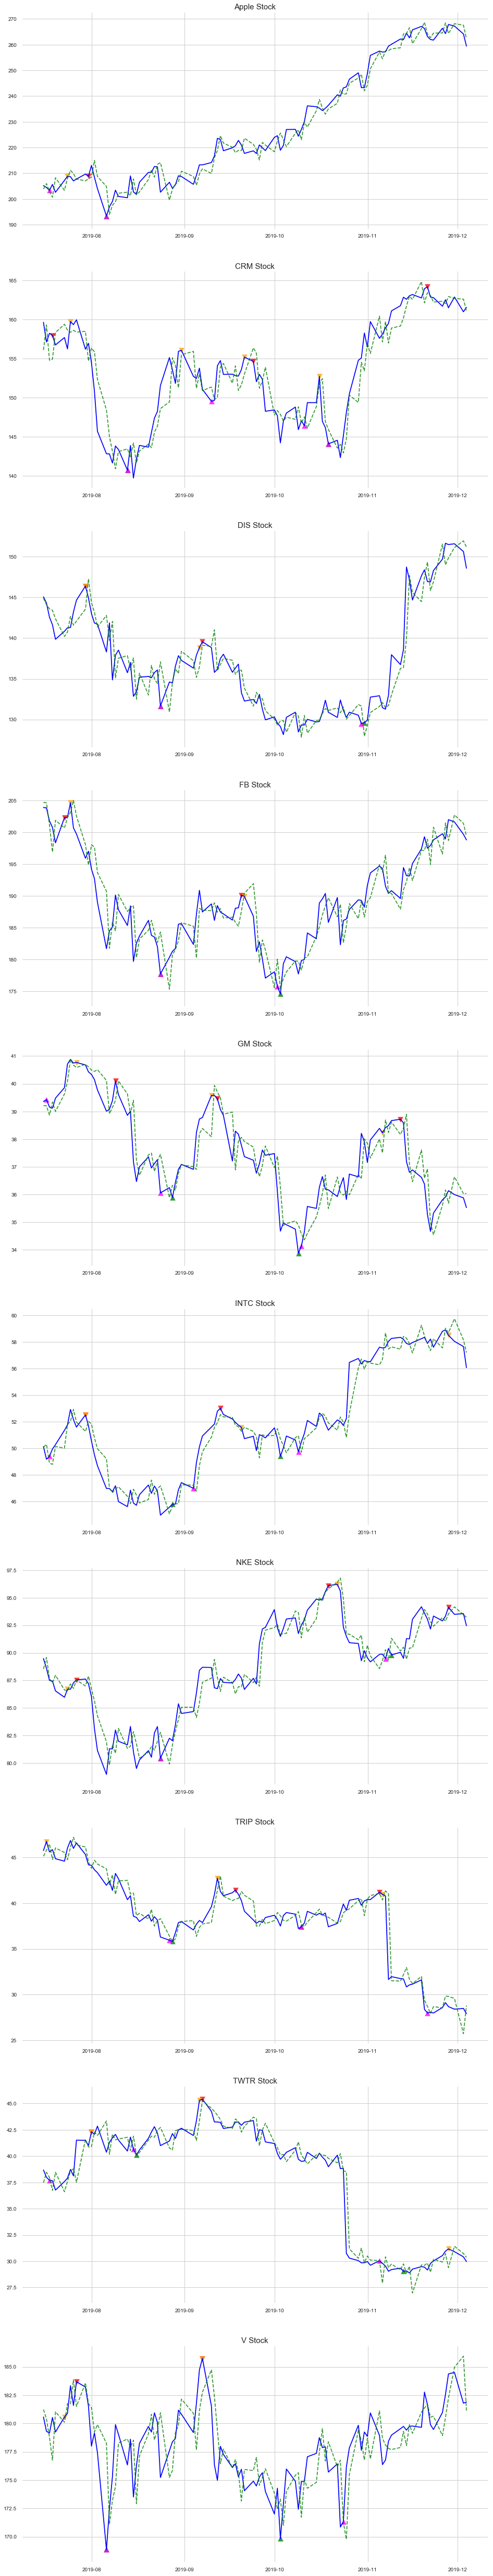

In [71]:
# Plot Graphs for Stocks
fig, axes = plt.subplots(nrows=10, figsize=(16,90))
axes[0].set_title("Apple Stock", fontsize=15)
axes[0].plot(aapl_test['2019'].index,aapl_test['2019']['close_price'],c='b') # first plot
axes[0].plot(aapl_test['2019'].index,aapl_test['2019']['predicted_price'], c='g', alpha = 0.8, linestyle='dashed') # first plot
axes[0].scatter(aapl_test['2019'][aapl_test['reversal']==1].index, aapl_test['2019'][aapl_test['reversal']==1]['close_price'], marker = '^', c='g', s = 100, alpha = 0.8)
axes[0].scatter(aapl_test['2019'][aapl_test['reversal']==2].index, aapl_test['2019'][aapl_test['reversal']==2]['close_price'], marker = 'v', c='r', s = 100, alpha = 0.8)
axes[0].scatter(aapl_test['2019'][aapl_test['predicted_reversal']==1].index, aapl_test['2019'][aapl_test['predicted_reversal']==1]['close_price'], marker = '^', c='magenta', s = 100, alpha = 0.8)
axes[0].scatter(aapl_test['2019'][aapl_test['predicted_reversal']==2].index, aapl_test['2019'][aapl_test['predicted_reversal']==2]['close_price'], marker = 'v', c='orange', s = 100, alpha = 0.8)

axes[1].set_title("CRM Stock", fontsize=15)
axes[1].plot(crm_test['2019'].index,crm_test['2019']['close_price'],c='b') # first plot
axes[1].plot(crm_test['2019'].index,crm_test['2019']['predicted_price'], c='g', alpha = 0.8, linestyle='dashed') # first plot
axes[1].scatter(crm_test['2019'][crm_test['reversal']==1].index, crm_test['2019'][crm_test['reversal']==1]['close_price'], marker = '^', c='g', s = 100, alpha = 0.8)
axes[1].scatter(crm_test['2019'][crm_test['reversal']==2].index, crm_test['2019'][crm_test['reversal']==2]['close_price'], marker = 'v', c='r', s = 100, alpha = 0.8)
axes[1].scatter(crm_test['2019'][crm_test['predicted_reversal']==1].index, crm_test['2019'][crm_test['predicted_reversal']==1]['close_price'], marker = '^', c='magenta', s = 100, alpha = 0.8)
axes[1].scatter(crm_test['2019'][crm_test['predicted_reversal']==2].index, crm_test['2019'][crm_test['predicted_reversal']==2]['close_price'], marker = 'v', c='orange', s = 100, alpha = 0.8)

axes[2].set_title("DIS Stock", fontsize=15)
axes[2].plot(dis_test['2019'].index,dis_test['2019']['close_price'],c='b') # first plot
axes[2].plot(dis_test['2019'].index,dis_test['2019']['predicted_price'], c='g', alpha = 0.8, linestyle='dashed') # first plot
axes[2].scatter(dis_test['2019'][dis_test['reversal']==1].index, dis_test['2019'][dis_test['reversal']==1]['close_price'], marker = '^', c='g', s = 100, alpha = 0.8)
axes[2].scatter(dis_test['2019'][dis_test['reversal']==2].index, dis_test['2019'][dis_test['reversal']==2]['close_price'], marker = 'v', c='r', s = 100, alpha = 0.8)
axes[2].scatter(dis_test['2019'][dis_test['predicted_reversal']==1].index, dis_test['2019'][dis_test['predicted_reversal']==1]['close_price'], marker = '^', c='magenta', s = 100, alpha = 0.8)
axes[2].scatter(dis_test['2019'][dis_test['predicted_reversal']==2].index, dis_test['2019'][dis_test['predicted_reversal']==2]['close_price'], marker = 'v', c='orange', s = 100, alpha = 0.8)

axes[3].set_title("FB Stock", fontsize=15)
axes[3].plot(fb_test['2019'].index,fb_test['2019']['close_price'],c='b') # first plot
axes[3].plot(fb_test['2019'].index,fb_test['2019']['predicted_price'], c='g', alpha = 0.8, linestyle='dashed') # first plot
axes[3].scatter(fb_test['2019'][fb_test['reversal']==1].index, fb_test['2019'][fb_test['reversal']==1]['close_price'], marker = '^', c='g', s = 100, alpha = 0.8)
axes[3].scatter(fb_test['2019'][fb_test['reversal']==2].index, fb_test['2019'][fb_test['reversal']==2]['close_price'], marker = 'v', c='r', s = 100, alpha = 0.8)
axes[3].scatter(fb_test['2019'][fb_test['predicted_reversal']==1].index, fb_test['2019'][fb_test['predicted_reversal']==1]['close_price'], marker = '^', c='magenta', s = 100, alpha = 0.8)
axes[3].scatter(fb_test['2019'][fb_test['predicted_reversal']==2].index, fb_test['2019'][fb_test['predicted_reversal']==2]['close_price'], marker = 'v', c='orange', s = 100, alpha = 0.8)

axes[4].set_title("GM Stock", fontsize=15)
axes[4].plot(gm_test['2019'].index,gm_test['2019']['close_price'],c='b') # first plot
axes[4].plot(gm_test['2019'].index,gm_test['2019']['predicted_price'], c='g', alpha = 0.8, linestyle='dashed') # first plot
axes[4].scatter(gm_test['2019'][gm_test['reversal']==1].index, gm_test['2019'][gm_test['reversal']==1]['close_price'], marker = '^', c='g', s = 100, alpha = 0.8)
axes[4].scatter(gm_test['2019'][gm_test['reversal']==2].index, gm_test['2019'][gm_test['reversal']==2]['close_price'], marker = 'v', c='r', s = 100, alpha = 0.8)
axes[4].scatter(gm_test['2019'][gm_test['predicted_reversal']==1].index, gm_test['2019'][gm_test['predicted_reversal']==1]['close_price'], marker = '^', c='magenta', s = 100, alpha = 0.8)
axes[4].scatter(gm_test['2019'][gm_test['predicted_reversal']==2].index, gm_test['2019'][gm_test['predicted_reversal']==2]['close_price'], marker = 'v', c='orange', s = 100, alpha = 0.8)

axes[5].set_title("INTC Stock", fontsize=15)
axes[5].plot(intc_test['2019'].index,intc_test['2019']['close_price'],c='b') # first plot
axes[5].plot(intc_test['2019'].index,intc_test['2019']['predicted_price'], c='g', alpha = 0.8, linestyle='dashed') # first plot
axes[5].scatter(intc_test['2019'][intc_test['reversal']==1].index, intc_test['2019'][intc_test['reversal']==1]['close_price'], marker = '^', c='g', s = 100, alpha = 0.8)
axes[5].scatter(intc_test['2019'][intc_test['reversal']==2].index, intc_test['2019'][intc_test['reversal']==2]['close_price'], marker = 'v', c='r', s = 100, alpha = 0.8)
axes[5].scatter(intc_test['2019'][intc_test['predicted_reversal']==1].index, intc_test['2019'][intc_test['predicted_reversal']==1]['close_price'], marker = '^', c='magenta', s = 100, alpha = 0.8)
axes[5].scatter(intc_test['2019'][intc_test['predicted_reversal']==2].index, intc_test['2019'][intc_test['predicted_reversal']==2]['close_price'], marker = 'v', c='orange', s = 100, alpha = 0.8)

axes[6].set_title("NKE Stock", fontsize=15)
axes[6].plot(nke_test['2019'].index,nke_test['2019']['close_price'],c='b') # first plot
axes[6].plot(nke_test['2019'].index,nke_test['2019']['predicted_price'], c='g', alpha = 0.8, linestyle='dashed') # first plot
axes[6].scatter(nke_test['2019'][nke_test['reversal']==1].index, nke_test['2019'][nke_test['reversal']==1]['close_price'], marker = '^', c='g', s = 100, alpha = 0.8)
axes[6].scatter(nke_test['2019'][nke_test['reversal']==2].index, nke_test['2019'][nke_test['reversal']==2]['close_price'], marker = 'v', c='r', s = 100, alpha = 0.8)
axes[6].scatter(nke_test['2019'][nke_test['predicted_reversal']==1].index, nke_test['2019'][nke_test['predicted_reversal']==1]['close_price'], marker = '^', c='magenta', s = 100, alpha = 0.8)
axes[6].scatter(nke_test['2019'][nke_test['predicted_reversal']==2].index, nke_test['2019'][nke_test['predicted_reversal']==2]['close_price'], marker = 'v', c='orange', s = 100, alpha = 0.8)

axes[7].set_title("TRIP Stock", fontsize=15)
axes[7].plot(trip_test['2019'].index,trip_test['2019']['close_price'],c='b') # first plot
axes[7].plot(trip_test['2019'].index,trip_test['2019']['predicted_price'], c='g', alpha = 0.8, linestyle='dashed') # first plot
axes[7].scatter(trip_test['2019'][trip_test['reversal']==1].index, trip_test['2019'][trip_test['reversal']==1]['close_price'], marker = '^', c='g', s = 100, alpha = 0.8)
axes[7].scatter(trip_test['2019'][trip_test['reversal']==2].index, trip_test['2019'][trip_test['reversal']==2]['close_price'], marker = 'v', c='r', s = 100, alpha = 0.8)
axes[7].scatter(trip_test['2019'][trip_test['predicted_reversal']==1].index, trip_test['2019'][trip_test['predicted_reversal']==1]['close_price'], marker = '^', c='magenta', s = 100, alpha = 0.8)
axes[7].scatter(trip_test['2019'][trip_test['predicted_reversal']==2].index, trip_test['2019'][trip_test['predicted_reversal']==2]['close_price'], marker = 'v', c='orange', s = 100, alpha = 0.8)

axes[8].set_title("TWTR Stock", fontsize=15)
axes[8].plot(twtr_test['2019'].index,twtr_test['2019']['close_price'],c='b') # first plot
axes[8].plot(twtr_test['2019'].index,twtr_test['2019']['predicted_price'], c='g', alpha = 0.8, linestyle='dashed') # first plot
axes[8].scatter(twtr_test['2019'][twtr_test['reversal']==1].index, twtr_test['2019'][twtr_test['reversal']==1]['close_price'], marker = '^', c='g', s = 100, alpha = 0.8)
axes[8].scatter(twtr_test['2019'][twtr_test['reversal']==2].index, twtr_test['2019'][twtr_test['reversal']==2]['close_price'], marker = 'v', c='r', s = 100, alpha = 0.8)
axes[8].scatter(twtr_test['2019'][twtr_test['predicted_reversal']==1].index, twtr_test['2019'][twtr_test['predicted_reversal']==1]['close_price'], marker = '^', c='magenta', s = 100, alpha = 0.8)
axes[8].scatter(twtr_test['2019'][twtr_test['predicted_reversal']==2].index, twtr_test['2019'][twtr_test['predicted_reversal']==2]['close_price'], marker = 'v', c='orange', s = 100, alpha = 0.8)

axes[9].set_title("V Stock", fontsize=15)
axes[9].plot(v_test['2019'].index,v_test['2019']['close_price'],c='b') # first plot
axes[9].plot(v_test['2019'].index,v_test['2019']['predicted_price'], c='g', alpha = 0.8, linestyle='dashed') # first plot
axes[9].scatter(v_test['2019'][v_test['reversal']==1].index, v_test['2019'][v_test['reversal']==1]['close_price'], marker = '^', c='g', s = 100, alpha = 0.8)
axes[9].scatter(v_test['2019'][v_test['reversal']==2].index, v_test['2019'][v_test['reversal']==2]['close_price'], marker = 'v', c='r', s = 100, alpha = 0.8)
axes[9].scatter(v_test['2019'][v_test['predicted_reversal']==1].index, v_test['2019'][v_test['predicted_reversal']==1]['close_price'], marker = '^', c='magenta', s = 100, alpha = 0.8)
axes[9].scatter(v_test['2019'][v_test['predicted_reversal']==2].index, v_test['2019'][v_test['predicted_reversal']==2]['close_price'], marker = 'v', c='orange', s = 100, alpha = 0.8)

The Graph above shows the test period.

The Actual price is shown in **Blue line**, Predicted price is in **Green-Dotted line**.

Actual Buy Point(Reversal) is shown as a **Green up triangle**, Sell Point(Reversal) is shown as **Red down triangle**.

Predicted Buy Point(Reversal) is shown as a **Purple up triangle**, Sell Point(Reversal) is shown as **Orange down triangle**.

From what we can see from the graphs, most of the predicted reversal points are not exactly the same as the actual reversal points. However, most of the actual reversal points and predicted reversal points are only a few days apart or the price levels between the point are pretty similar.

Hence, I would say the results are still quite acceptable even though the confusion matrix and f1 score used as metrics performed quite badly.

# Conclusion

In this project, I selected the best SARIMA model because the machine learning models does not seem to be very efficient in forecasting the prices properly even though some of the models have low RMSE scores. XGBoost and lassoCV Model have about 20 RMSE, however, it can be seen that the model's predicted values is only just following the actual price but with a lag of 10 periods. It is unable to do actual forecasting. Hence, I decided to go with SARIMA model.

SARIMA is able to forcast for about 10 to 15 periods before being unable to forecast any more price changes. Although it is not the best model as it would not be able to capture any sudden huge prices changes, at the moment it is still able to achieve what I would like to achieve, which is to forecast prices 13 periods ahead.

Using the forecasted prices, I am able to pinpoint current reversal point.

***Future Work***

Futher Testing is required to determine if this model is truely reliable in predicting reversal points.
I will be testing the results in the financial markets and record the results for confirmation.

Further work will need to be done in the future to create a model that would be able to forecast higher periods of prices with accuracy. SARIMA is just the starting point.

## Future Progress

1) Real Time Scraping (Deployment)
     - Real time Scrape every hour
     - Update Dataset with Scraped Data
     - Run Model on Scraped Data to Forecast Price (Dont need to Train Test Split)
     - Combine Forecasted Price with Actual Price
     - Create Columns required for Labeling
     - Run Labeling Function
     - If there is a reversal point at current time, notify me (Popup? Auto Telegram Self?)
     - Test on brokerage of your choice
     - Update Results on Excel Sheet to calculate returns

2) Things I can look into to improve forecasting model
    - Fourior transformation
    - Anomaly Detection
    - Adversarial AutoEncoders neural network
    - CNN + LSTM Forecast
    - Stacked Models
    - SARIMAX
    - SARIMAX/SARIMA + GARCH
    - Include News Sentiment analysis as a feature / Fundamental data as features
    
3) Using different metric to determine success
    - Evaluating Accuracy of Model Classification
    - Use Different Metric to determine best GridSearch Results
    
[Additional Readups](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424)

[More details on ARCH/GARCH](https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/)

***SARIMA + GARCH***

Autoregressive models can be developed for univariate time series data that is stationary (AR), has a trend (ARIMA), and has a seasonal component (SARIMA).

One aspect of a univariate time series that these autoregressive models do not model is a change in the variance over time.

n time series where the variance is increasing in a systematic way, such as an increasing trend, this property of the series is called heteroskedasticity. It’s a fancy word from statistics that means changing or unequal variance across the series.

If the change in variance can be correlated over time, then it can be modeled using an autoregressive process, such as ARCH.

The approach expects the series is stationary, other than the change in variance, meaning it does not have a trend or seasonal component. An ARCH model is used to predict the variance at future time steps.

    The model should only be applied to a prewhitened residual series {e_t} that is uncorrelated and contains no trends or seasonal changes, such as might be obtained after fitting a satisfactory SARIMA model.

— Page 148, Introductory Time Series with R, 2009.

**I will be using the GARCH Model.**

Generalized Autoregressive Conditional Heteroskedasticity, or GARCH, is an extension of the ARCH model that incorporates a moving average component together with the autoregressive component.

As such, the model introduces a new parameter “p” that describes the number of lag variance terms:

    p: The number of lag variances to include in the GARCH model.
    q: The number of lag residual errors to include in the GARCH model.
